# South Australia Solar Supply Forecast

---

As South Australia progresses toward its 100% renewable energy target by 2030, having robust forecasting tools becomes ever more critical to maintain reliability as dependency on solar/wind increases. This project aims to forecast energy supply from solar photovoltaic (PV) in South Australia; a crucial step toward shaping sustainable energy strategies for the region.

### Data Source

Our data is collected with [OpenNEM API](https://opennem.org.au/) and [Open Meteo API](https://open-meteo.com/), made available under [CC BY 4.0 License](https://creativecommons.org/licenses/by/4.0/).

### Analysis Tool

We will be using Python 3 in this project.

---

## Importing File

We import the file `extracted.csv` which is extracted from OpenNEM and Open Meteo's API. The extracting script can rom `etl.py`.

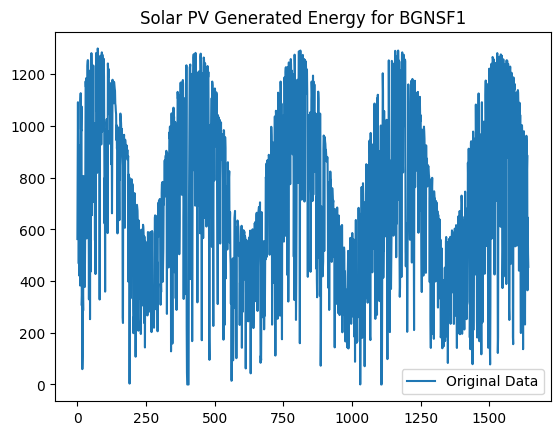

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Import data
DATA = pd.read_csv("extracted.csv")

# I'll set aside 10% verification data
DATA_LOC1 = DATA[DATA["Name"] == "BNGSF1"]
VERI = DATA_LOC1[-round(0.1*len(DATA_LOC1)):]
df = DATA_LOC1[:-round(0.1*len(DATA_LOC1))]

# TIme series preview
plt.close()
plt.plot(df["Energy"], label = "Original Data")
plt.title("Solar PV Generated Energy for BGNSF1")
plt.legend()
plt.show()

## Time Series Modeling



In [4]:
# Candidate models

def simple_exp_smooth_model(df):
    model = SimpleExpSmoothing(df["Energy"])
    return model.fit().forecast(1).iloc[0]

def seasonal_recent_model(df):
    # Based on "stabilised" seasonal pattern + recency
    gap = 365
    return (df.iloc[(len(df)-gap-3):(len(df)-gap+3), ]["Energy"].mean() + df.iloc[len(df)-1, ]["Energy"])/2

def arima_model(df): # From auto arima: 1, 1, 1
    # ARIMA (1, 1, 1)
    exogenous_features = ["Mean Temperature", "Max Temperature", "Min Temperature"]
    model = auto_arima(
        train["Energy"],
        exogenous=train[exogenous_features],
        trace=True,
        error_action="ignore",
	    suppress_warnings=True)
    return model.predict(n_periods=1,  exogenous=df_valid[exogenous_features])

# ===

def experimental_model(df):
    # Template for trying stuff
    return 0

In [5]:
# Benchmark models

def mean_model(df):
    return df["Energy"].mean()

def k_mean_model(df, k=7):
    return df.iloc[(len(df)-k-1):(len(df)-1), ]["Energy"].mean()

def naive_model(df):
    return df.iloc[len(df)-1, ]["Energy"]

def seasonal_model(df):
    gap = 365
    return df.iloc[len(df)-gap, ]["Energy"]

def drift_model(df):
    start = df.iloc[0, ]
    end = df.iloc[len(df)-1, ]
    return end["Energy"] + (end["Energy"]-start["Energy"])/(end["Date"]-start["Date"]).days * 1

def sine_model(df):
    initial_guess = [350, 1/365, 300, 960]
    popt, _ = curve_fit(sinusoidal_func, range(len(df)), df["Energy"], p0=initial_guess)
    return sinusoidal_func(len(df), *popt)

In [6]:
# Small pipeline
models = {
    "simple-exp-smooth": simple_exp_smooth_model, # MSE 260 for (800-1600, given 400 data), less variance
    "seasonal-recent": seasonal_recent_model, # 255
    "arima": arima_model,
    "mean": mean_model, # MSE 320
    "k-mean": k_mean_model,
    "naive": naive_model, # MSE 290
    "drift": drift_model, # MSE 290
    "sine": sine_model, # MSE 260
    "experimental": experimental_model
}